In [ ]:
# conda create -n vs-intint -c pytorch -c conda-forge seaborn tqdm pytorch torchaudio jupyterlab
# conda activate vs-intint
# jupyter-lab

In [1]:
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchaudio
from IPython.display import Audio

In [2]:
%matplotlib inline

In [3]:
wave, sr = torchaudio.load('/Users/victor/Music/sample/VSCO-2-CE/Woodwinds/Oboe/Vib/Oboe_Vib_D3_v3_Main.wav')

In [4]:
wave.shape

torch.Size([2, 304847])

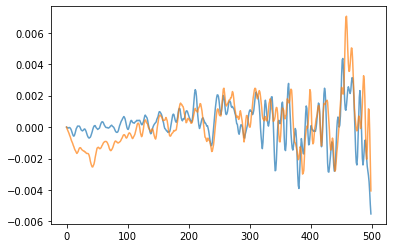

In [5]:
for chan in wave.unbind(0):
    plt.plot(chan[:500], alpha=0.7)

In [6]:
mono = wave.mean(0)

In [7]:
def preemph(x, a=1.1):
    x_ = torch.cat((torch.zeros_like(x[:1]), x), 0)
    y = a*x_[1:] - x_[:-1]
    return y
    
def deemph(ys, a=1.1):
    x_ = torch.zeros_like(ys[:1])
    xs = []
    for y in ys:
        x = (y + x_)/a
        x_ = x
        xs.append(x)
    return torch.cat(xs, 0)

In [8]:
filt = preemph(mono)

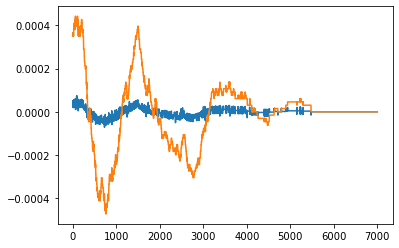

In [201]:
plt.plot(filt[-7000:])
plt.plot(mono[-7000:])

## time-regressive

In [10]:
t = torch.arange(len(filt))/sr

In [14]:
n_freq = 256
f_lo, f_hi = 0.1, sr/2
freq = torch.linspace(math.log(f_lo), math.log(f_hi), n_freq).exp()
phase = freq * t[:,None] * math.pi * 2
feat = torch.cat((phase.sin(), phase.cos()), 1)

In [15]:
# freq

torch.Size([304847, 512])

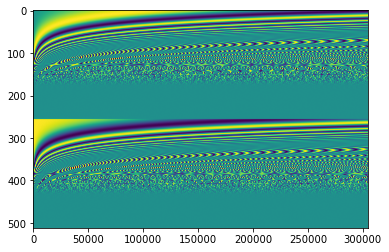

In [16]:
plt.imshow(feat.T, aspect='auto')
feat.shape

In [24]:
# TODO: time jit version
# TODO: effect of dropout?
h = 256
model = (#torch.jit.script(
    nn.Sequential(
#         nn.Dropout(0.5), 
        nn.Linear(2*n_freq, h), nn.ReLU(),# nn.Dropout(0.1),
        nn.Linear(h, h), nn.ReLU(), #nn.Dropout(0.1),
        nn.Linear(h, h), nn.ReLU(), #nn.Dropout(0.1),
        nn.Linear(h, 1, bias=False), nn.Tanh()
    )
)

In [25]:
seen_idx = torch.zeros(len(filt))

In [26]:
batch_size = 1024

In [27]:
# TODO: learning rate
opt = torch.optim.Adam(model.parameters(), 1e-3)
losses = []

100%|██████████| 100000/100000 [54:15<00:00, 30.72it/s] 


0.0002536920364946127

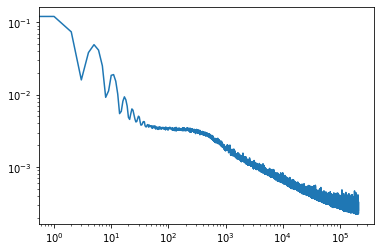

In [84]:
model.train()
for _ in tqdm(range(100000)):
    model.zero_grad()
    idx = torch.multinomial((3*(seen_idx.mean()-seen_idx)).exp(), batch_size)
    batch = feat[idx, :]
    target = filt[idx]
    seen_idx[idx] += 1
#     batch = feat[:1000]
#     target = mono[:1000]
    result = model(batch)[:,0]
    loss = (result - target).abs().mean()
#     loss = (result - target).pow(2).sum().sqrt()
    loss.backward()
    opt.step()
    losses.append(loss.item())
model.eval()
plt.plot(losses)
plt.loglog()
loss.item()

In [85]:
recon = deemph(model(feat)[:,0])
recon.shape

torch.Size([304847])

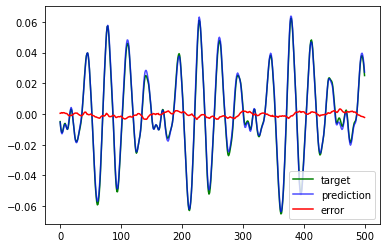

In [86]:
s,d=2000,500
# s,d=1000,200
plt.plot(mono[s:s+d], label='target', c='g')
plt.plot((recon).detach()[s:s+d], label='prediction', c='b', alpha=0.7)
plt.plot((mono-recon).detach()[s:s+d], label='error', c='r')
plt.legend()

In [87]:
spect = torchaudio.transforms.Spectrogram(4096, sr//25, sr//100)
eps = 1e-6

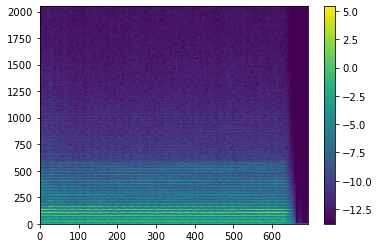

In [88]:
recon_spect = (spect(recon.detach())+eps).log()
plt.imshow(recon_spect, aspect='auto', origin='lower')
plt.colorbar()

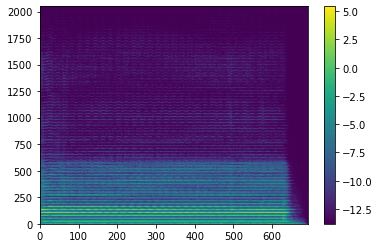

In [89]:
gt_spect = (spect(mono)+eps).log()
plt.imshow(gt_spect, aspect='auto', origin='lower')
plt.colorbar()

In [90]:
display('reconstruction', Audio(recon.detach(), rate=sr))
display('ground truth', Audio(mono, rate=sr))

'reconstruction'

'ground truth'

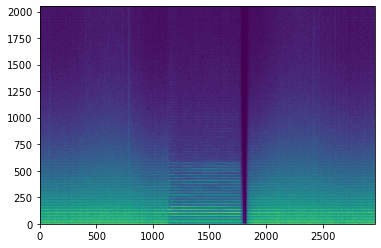

In [91]:
t_ext = torch.arange(-500000, len(mono)+500000)/sr
phase_ext = freq * t_ext[:,None] * math.pi * 2
feat_ext = torch.cat((phase_ext.sin(), phase_ext.cos()), 1)
ext = deemph(model(feat_ext)[:,0].detach())
ext_spect = (spect(ext)+eps).log()
plt.imshow(ext_spect, aspect='auto', origin='lower')

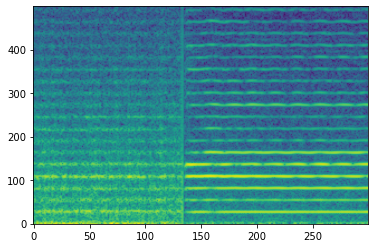

In [92]:
plt.imshow(ext_spect[:500,1000:1300], aspect='auto', origin='lower')

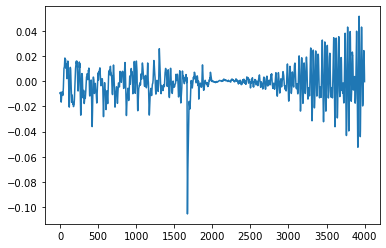

In [93]:
plt.plot(ext[498000:502000])

In [94]:
display('extrapolation', Audio(ext, rate=sr))

'extrapolation'

## autoregressive

In [234]:
h = 256
k = 3
n = 128
sigma = 1/filt.std()
model = (#torch.jit.script(
    nn.Sequential(
#         nn.Dropout(0.5), 
        nn.Linear(2*n, h), nn.ReLU(),# nn.Dropout(0.1),
        nn.Linear(h, h), nn.ReLU(), #nn.Dropout(0.1),
        nn.Linear(h, h), nn.ReLU(), #nn.Dropout(0.1),
        nn.Linear(h, 1), nn.Tanh()
    )
)

In [224]:
prev = torch.stack([
    torch.cat((filt[-i:], filt[:-i])) for i in range(1, k+1)
], -1)
prev.shape

torch.Size([304847, 3])

In [226]:
freqs = torch.randn(3,n)*sigma
# freqs

In [228]:
phase = (prev @ freqs * 2*math.pi)
feat = torch.cat((phase.sin(), phase.cos()), -1)
feat.shape

torch.Size([304847, 256])

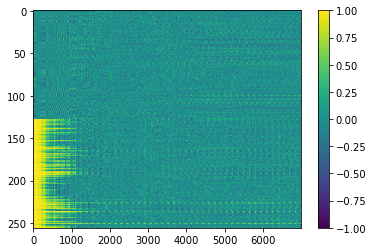

In [242]:
plt.imshow(feat[:7000].T, aspect='auto')
plt.colorbar()

In [230]:
seen_idx = torch.zeros(len(filt))

In [231]:
batch_size = 1024

In [235]:
# TODO: learning rate
opt = torch.optim.Adam(model.parameters(), 1e-3)
losses = []

100%|██████████| 10000/10000 [05:08<00:00, 32.46it/s]


0.0003271375026088208

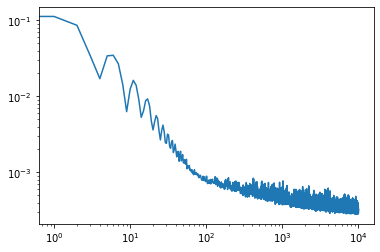

In [236]:
model.train()
for _ in tqdm(range(10000)):
    model.zero_grad()
    idx = torch.multinomial((3*(seen_idx.mean()-seen_idx)).exp(), batch_size)
    batch = feat[idx, :]
    target = filt[idx]
    seen_idx[idx] += 1
    result = model(batch)[:,0]
    loss = (result - target).abs().mean()
#     loss = (result - target).pow(2).sum().sqrt()
    loss.backward()
    opt.step()
    losses.append(loss.item())
model.eval()
plt.plot(losses)
plt.loglog()
loss.item()

In [237]:
filt.mean(), model[-2].bias

(tensor(6.1048e-07),
 Parameter containing:
 tensor([-0.0120], requires_grad=True))

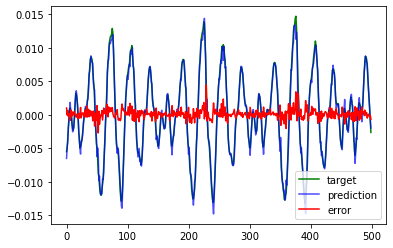

In [243]:
s,d=2000,500
force_recon = model(feat)[:,0]#deemph(model(prev)[:,0])
plt.plot(filt[s:s+d], label='target', c='g')
plt.plot((force_recon).detach()[s:s+d], label='prediction', c='b', alpha=0.7)
plt.plot((filt-force_recon).detach()[s:s+d], label='error', c='r')
plt.legend()

In [250]:
samp = torch.empty_like(filt)
for i in range(k):
    samp[i] = filt[i]
for i in tqdm(range(k, len(samp))):
    prv = samp[None,i-k:i]
    ft = prv@freqs * 2*math.pi
    ft = torch.cat((ft.sin(), ft.cos()),-1)
    samp[i] = model(ft)[0,0]
recon = deemph(samp)
recon.shape

100%|██████████| 304844/304844 [01:49<00:00, 2782.06it/s]


torch.Size([304847])

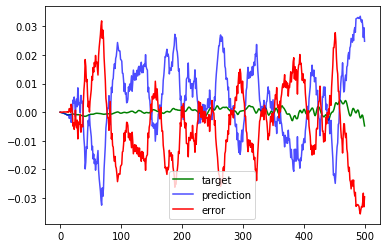

In [251]:
s,d=0,500
# s,d=1000,200
plt.plot(mono[s:s+d], label='target', c='g')
plt.plot((recon).detach()[s:s+d], label='prediction', c='b', alpha=0.7)
plt.plot((mono-recon).detach()[s:s+d], label='error', c='r')
plt.legend()

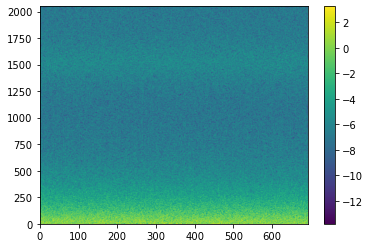

In [252]:
recon_spect = (spect(recon.detach())+eps).log()
plt.imshow(recon_spect, aspect='auto', origin='lower')
plt.colorbar()

In [186]:
display('reconstruction', Audio(recon.detach(), rate=sr))
display('ground truth', Audio(mono, rate=sr))

'reconstruction'

'ground truth'